## Import Data

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier  
from wordcloud import WordCloud
from collections import Counter
import re
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE 
import Sastrawi
import pickle

In [3]:
df = pd.read_csv('Review Instagram 2024.csv')
df.head()

,userName,content,sentiment,at
0,Su Wignyo,"Gatau ig skrng banyak bug nya. Mulai dari, pos...",netral,2024-07-08 14:28:56
1,One ST,Tolong diperbaiki dong bug suara yg dipostinga...,negatif,2024-07-10 17:44:34
2,Karina Ramadhani,"gimana ya, ig makin kesini makin banyak bug ny...",negatif,2024-07-12 09:55:56
3,Cantika Fadiya Adillah,Kenapa ya akun Instagram saya ketiga²nya jika ...,negatif,2024-07-13 22:19:50
4,Vivo New,Saya suka intagram begitu banyak video bermanf...,positif,2024-07-14 08:34:27


## 1. Data Understanding

In [3]:
print('Data Shape :',df.shape)

Data Shape : (1000, 4)


In [4]:
df.columns

Index(['userName', 'content', 'sentiment', 'at'], dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userName   1000 non-null   object
 1   content    1000 non-null   object
 2   sentiment  1000 non-null   object
 3   at         1000 non-null   object
dtypes: object(4)
memory usage: 31.4+ KB


In [6]:
df.describe()

,userName,content,sentiment,at
count,1000,1000,1000,1000
unique,991,1000,3,1000
top,Pengguna Google,"Gatau ig skrng banyak bug nya. Mulai dari, pos...",negatif,2024-07-08 14:28:56
freq,8,1,647,1


## 2. Cleaning Data

In [7]:
print('Data Shape :',df.shape)

Data Shape : (1000, 4)


In [8]:
df.isnull().sum()

userName     0
content      0
sentiment    0
at           0
dtype: int64

In [9]:
df.dropna(inplace=True)

## 3. Exploratory Data Analysis

### Distribution of Sentiment

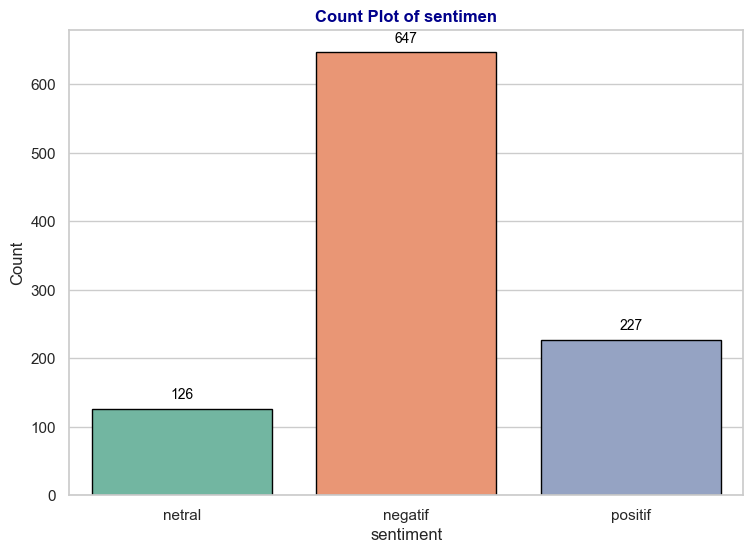

In [10]:
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
ax = sns.countplot(data=df, x='sentiment', palette="Set2", edgecolor="black")
plt.title(f'Count Plot of sentimen', fontweight='bold', color='darkblue')
plt.ylabel("Count", fontsize=12)
for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', 
                    xytext=(0, 5), textcoords='offset points', fontsize=10, color='black')
plt.tight_layout(pad=2)
plt.show()

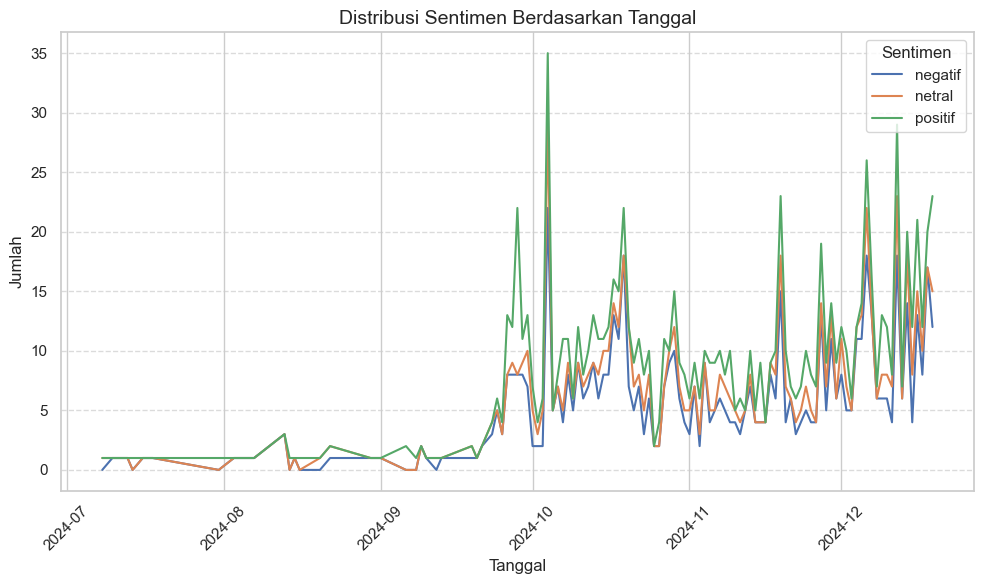

In [11]:
df['at'] = pd.to_datetime(df['at']).dt.date
# Menghitung distribusi sentimen per tanggal
sentiment_distribution = df.groupby(['at', 'sentiment']).size().unstack(fill_value=0)

# Plot distribusi sentimen
sentiment_distribution.plot(kind='line', stacked=True, figsize=(10, 6))

# Menambahkan detail pada plot
plt.title('Distribusi Sentimen Berdasarkan Tanggal', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sentimen', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menampilkan plot
plt.tight_layout()
plt.show()

### Visualisasi Kata

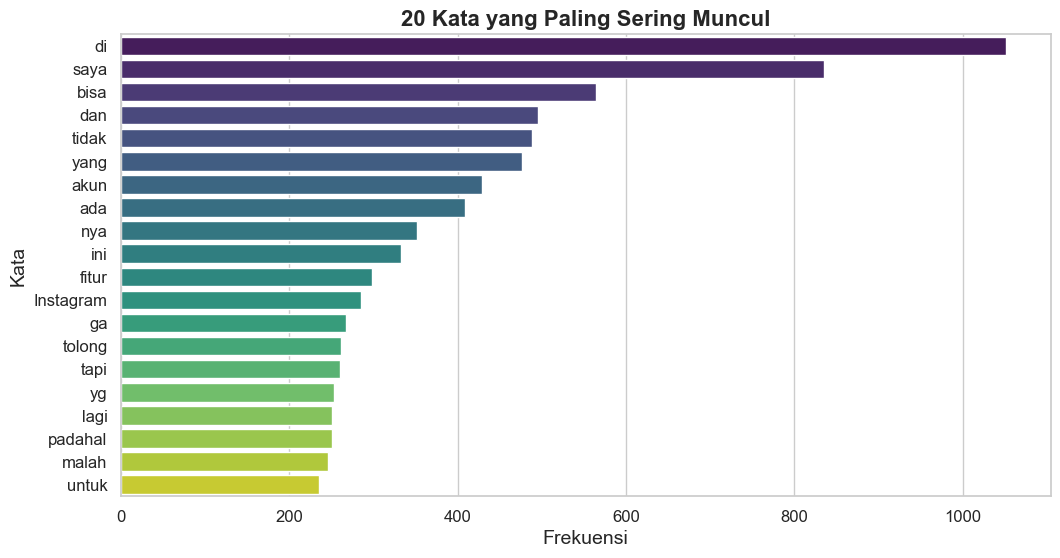

In [12]:
# Menggabungkan semua teks menjadi satu string
text = " ".join(df["content"])
tokens = text.split()

# Menghitung frekuensi kemunculan setiap kata
word_counts = Counter(tokens)

# Mengambil kata dengan frekuensi kemunculan tertinggi
top_words = word_counts.most_common(20)  # Ambil 20 kata teratas

# --- Visualisasi 1: Bar Chart ---
# Memisahkan kata dan jumlahnya
words, counts = zip(*top_words)

# Setup tema seaborn
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.title("20 Kata yang Paling Sering Muncul", fontsize=16, fontweight='bold')
plt.xlabel("Frekuensi", fontsize=14)
plt.ylabel("Kata", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

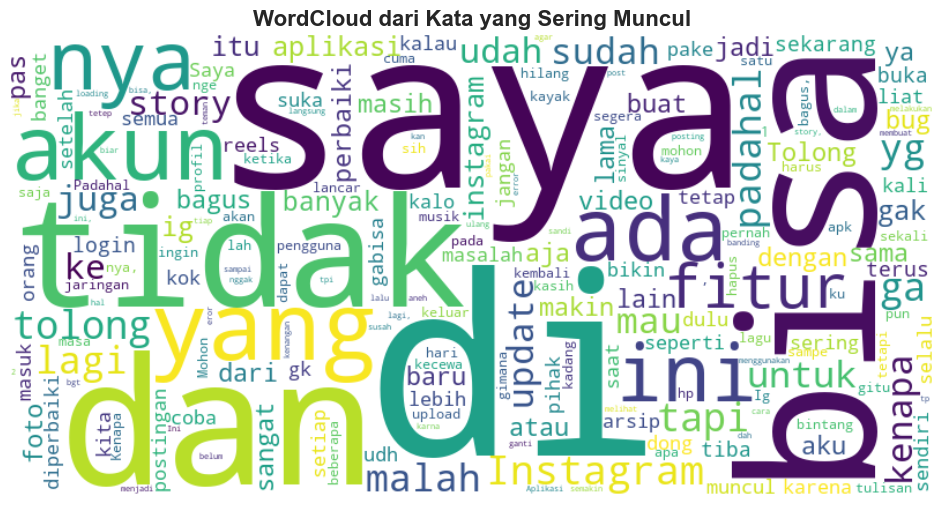

In [13]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate_from_frequencies(word_counts)

# Menampilkan WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud dari Kata yang Sering Muncul", fontsize=16, fontweight='bold')
plt.show()

Menyimpannya dalam csv

In [14]:
text = " ".join(df["text"])
tokens = text.split()

# Menghitung frekuensi kemunculan setiap kata
word_counts = Counter(tokens)

# Mengambil kata dengan frekuensi kemunculan tertinggi
top_words = word_counts.most_common(2000)

word, count = zip(*top_words)
data = pd.DataFrame({'Word': word, 'Count': count})

data.to_csv('word_frequency.csv', index=False)

## 4. Preprocessing Text

### Case Folding & Cleaning Text

In [15]:
def bersihkan_teks(teks):
    # Mengubah semua teks menjadi huruf kecil
    teks = teks.lower()
    
    # Menghapus link/URL
    teks = re.sub(r'http\S+|www\S+|https\S+', ' ', teks, flags=re.MULTILINE)
    
    # Menghapus emoji dan karakter non-ASCII
    teks = re.sub(r'[^\x00-\x7F]+', ' ', teks)
    
    # Menghapus tanda baca dan simbol lainnya
    teks = re.sub(r'[^a-zA-Z0-9\s]', ' ', teks)
    
    # Menghapus angka (opsional, jika tidak ingin menghapus angka, hapus baris ini)
    teks = re.sub(r'\d+', ' ', teks)
    
    # Menghapus spasi ganda yang mungkin terbentuk
    teks = re.sub(r'\s+', ' ', teks).strip()
    
    return teks
df['content'] = df['content'].apply(bersihkan_teks)

### Normalization

In [16]:
# Fungsi penggantian kata tidak baku
def replace_taboo_words(text, kamus_tidak_baku):
    if isinstance(text, str):
        words = text.split()
        replaced_words = []
        kalimat_baku = []
        kata_diganti = []
        kata_tidak_baku_hash = []

        for word in words:
            if word in kamus_tidak_baku:
                baku_word = kamus_tidak_baku[word]
                if isinstance(baku_word, str) and all(char.isalpha() for char in baku_word):
                    replaced_words.append(baku_word)
                    kalimat_baku.append(baku_word)
                    kata_diganti.append(word)
                    kata_tidak_baku_hash.append(hash(word))
            else:
                replaced_words.append(word)
        replaced_text = ' '.join(replaced_words)
    else:
        replaced_text = ''
        kalimat_baku = []
        kata_diganti = []
        kata_tidak_baku_hash = []

    return replaced_text, kalimat_baku, kata_diganti, kata_tidak_baku_hash

In [17]:
# Baca kamus kata tidak baku
kamus_data = pd.read_excel("kamusslag.xlsx")
kamus_tidak_baku = dict(zip(kamus_data['kata_tidak_baku'], kamus_data['kata_baku']))

In [18]:
# Terapkan fungsi penggantian kata tidak baku
df['Normalisasi'], df['Kata_Baku'], df['kata_tidak_baku'], df['Kata_Tidak_Baku_Hash'] = zip(*df['content'].apply(lambda x: replace_taboo_words(x, kamus_tidak_baku)))
df =  pd.DataFrame(df[['content','Normalisasi']])

### Tokenize

In [19]:
from nltk.tokenize import word_tokenize
df['Tokenize'] = df['Normalisasi'].apply(lambda x: word_tokenize(x))

### Stopwords

In [20]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Daftar stop words tambahan
more_stop_words = []

# Menggabungkan stop words bawaan NLTK dengan stop words tambahan
stop_words = set(stopwords.words('indonesian'))  # NLTK memiliki stop words untuk berbagai bahasa
stop_words.update(more_stop_words)  # Tambahkan stop words kustom

# Fungsi untuk menghapus stop words
def remove_stopwords(words):
    filtered_words = [word for word in words if word.lower() not in stop_words]  # Filter stop words
    return filtered_words

# Terapkan fungsi ke kolom 'Normalisasi'
df['Stopword'] = df['Tokenize'].apply(remove_stopwords)


### Stemming

In [21]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Membuat stemmer hanya sekali
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(words):
    # Stemming setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words if len(word) > 2]
    # Gabungkan kembali hasil stemming menjadi string
    clean_text = " ".join(stemmed_words)
    return clean_text

# Menerapkan stemming pada kolom Tokenize
df['Stemming'] = df['Stopword'].apply(lambda x: stemming(x))


In [22]:
df

,content,Normalisasi,Tokenize,Stopword,Stemming
0,gatau ig skrng banyak bug nya mulai dari posti...,instagram sekarang banyak bug nya mulai dari p...,"[instagram, sekarang, banyak, bug, nya, mulai,...","[instagram, bug, nya, postingan, suaranya, sim...",instagram bug nya postingan suara simbol speak...
1,tolong diperbaiki dong bug suara yg dipostinga...,tolong diperbaiki dong bug suara yang dipostin...,"[tolong, diperbaiki, dong, bug, suara, yang, d...","[tolong, diperbaiki, bug, suara, dipostingan, ...",tolong baik bug suara dipostingan postingan in...
2,gimana ya ig makin kesini makin banyak bug nya...,gimana ya instagram makin kesini makin banyak ...,"[gimana, ya, instagram, makin, kesini, makin, ...","[gimana, ya, instagram, kesini, bug, nya, makl...",gimana instagram kesini bug nya maklum bikin k...
3,kenapa ya akun instagram saya ketiga nya jika ...,kenapa ya akun instagram saya ketiga nya jika ...,"[kenapa, ya, akun, instagram, saya, ketiga, ny...","[ya, akun, instagram, ketiga, nya, menonton, v...",akun instagram tiga nya tonton video reels suk...
4,saya suka intagram begitu banyak video bermanf...,saya suka intagram begitu banyak video bermanf...,"[saya, suka, intagram, begitu, banyak, video, ...","[suka, intagram, video, bermanfaat, dalamnya, ...",suka intagram video manfaat dalam namu jarang ...
...,...,...,...,...,...
995,sangat membantu dalam informasi dan komunikasi...,sangat membantu dalam informasi dan komunikasi...,"[sangat, membantu, dalam, informasi, dan, komu...","[membantu, informasi, komunikasi, jarak, mempe...",bantu informasi komunikasi jarak mudah dengar ...
996,tolong deh diperbaiki bugnya kenapa setiap say...,tolong deh diperbaiki bugnya kenapa setiap say...,"[tolong, deh, diperbaiki, bugnya, kenapa, seti...","[tolong, deh, diperbaiki, bugnya, story, akun,...",tolong deh baik bugnya story akun muncul tulis...
997,tolong berikan fitur untuk menyembunyikan juml...,tolong berikan fitur untuk menyembunyikan juml...,"[tolong, berikan, fitur, untuk, menyembunyikan...","[tolong, fitur, menyembunyikan, pengikut, diik...",tolong fitur sembunyi ikut ikut fitur history ...
998,bagusin dlu bugnya setiap mau post malah nungg...,bagusin dulu bugnya setiap mau post malah tung...,"[bagusin, dulu, bugnya, setiap, mau, post, mal...","[bagusin, bugnya, post, tunggu, koneksi, dah, ...",bagusin bugnya post tunggu koneksi dah coba pa...


In [23]:
df.to_csv('hasil_preprocessing_data.csv',index=False)

## 5. Visualisasi setelah preprocessing

In [4]:
df1 = pd.read_csv('Review Instagram 2024.csv')
df2 = pd.read_csv('hasil_preprocessing_data.csv')
att1 = df1['sentiment']
att2 = df2['Stemming']
df = pd.concat([att2,att1],axis=1)

In [5]:
df.dropna(inplace=True)

In [6]:
df.shape

(1000, 2)

In [7]:
kata_positif = df[df['sentiment'] == 'positif']
sentimen_positif = kata_positif['Stemming']
kata_negatif = df[df['sentiment'] == 'negatif']
sentimen_negatif = kata_negatif['Stemming']
kata_netral = df[df['sentiment'] == 'netral']
sentimen_netral = kata_netral['Stemming']

### Visualisasi Sentiment Positif

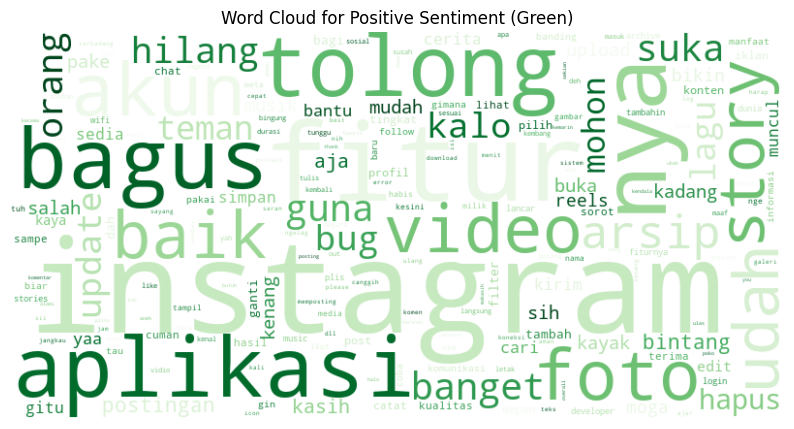

In [8]:
kata_positif = ' '.join(sentimen_positif)

# Tokenize the words and count frequency for positive sentiment
words_positif = kata_positif.split()
word_counts_positif = Counter(words_positif)

# Display the most common words for positive sentiment
common_words_positif = word_counts_positif.most_common(10)

# Create word cloud for positive sentiment with a green colormap
wordcloud_positif = WordCloud(
    width=800, height=400, background_color='white', colormap='Greens').generate_from_frequencies(word_counts_positif)

# Plotting the word cloud for positive sentiment
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_positif, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Positive Sentiment (Green)")
plt.show()

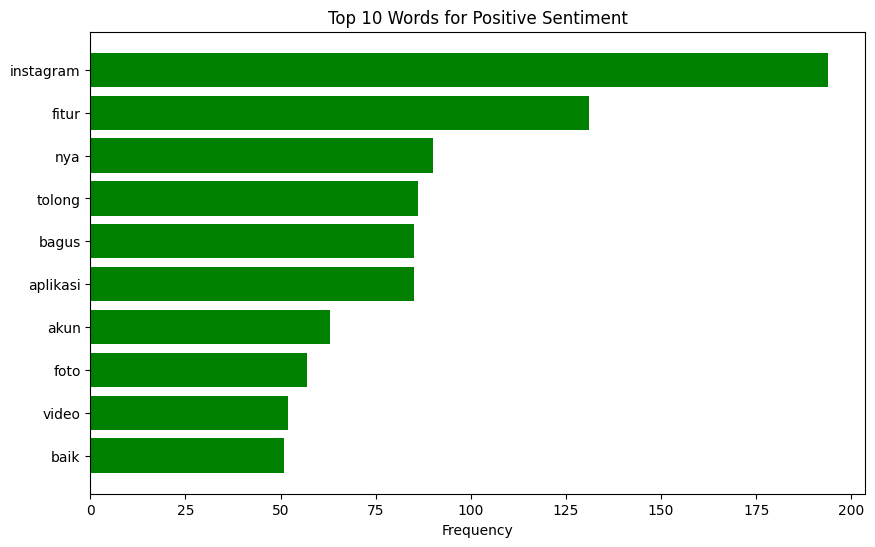

In [9]:
# Optional: Plot the top 10 words as bar plots for positive sentiment
top_words_positif = [word[0] for word in common_words_positif]
top_counts_positif = [word[1] for word in common_words_positif]

plt.figure(figsize=(10, 6))
plt.barh(top_words_positif, top_counts_positif, color='green')
plt.xlabel('Frequency')
plt.title('Top 10 Words for Positive Sentiment')
plt.gca().invert_yaxis()
plt.show()

### Visualisasi Sentiment Netral

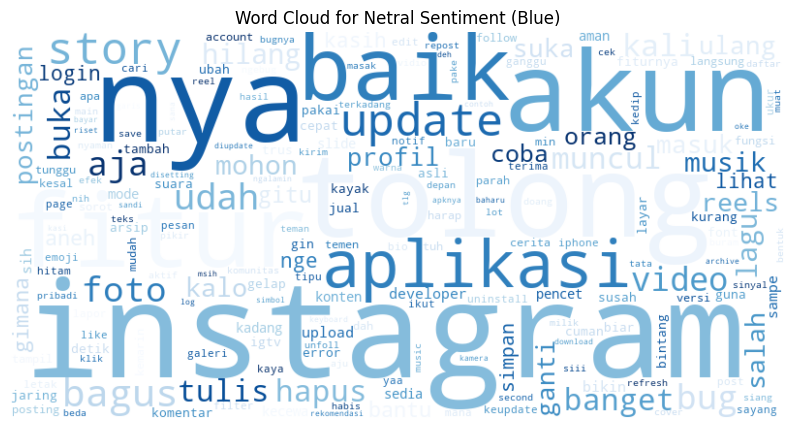

In [10]:
kata_netral = ' '.join(sentimen_netral)

# Tokenize the words and count frequency for netral sentiment
words_netral = kata_netral.split()
word_counts_netral = Counter(words_netral)

# Display the most common words for netral sentiment
common_words_netral = word_counts_netral.most_common(10)

# Create word cloud for netral sentiment with a red colormap
wordcloud_netral = WordCloud(
    width=800, height=400, background_color='white', colormap='Blues').generate_from_frequencies(word_counts_netral)

# Plotting the word cloud for netral sentiment
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_netral, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Netral Sentiment (Blue)")
plt.show()


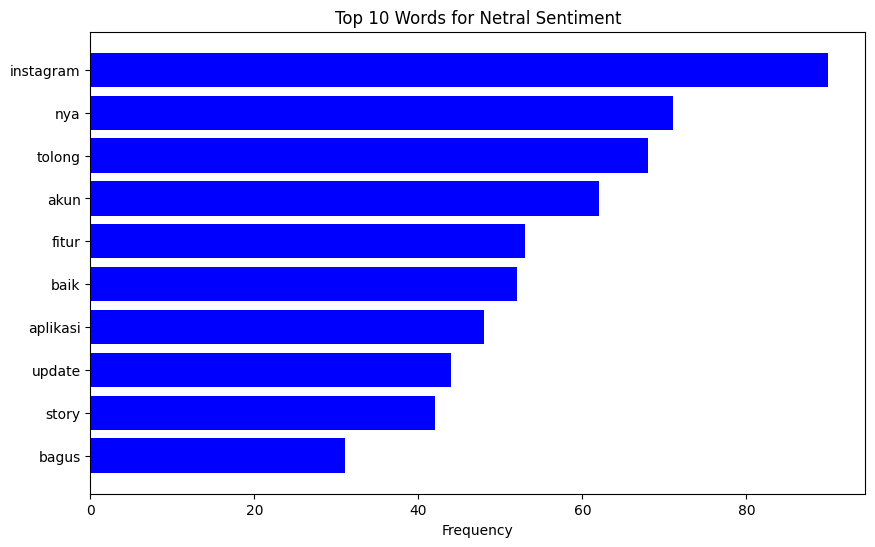

In [11]:
# Optional: Plot the top 10 words as bar plots for netral sentiment
top_words_netral = [word[0] for word in common_words_netral]
top_counts_netral = [word[1] for word in common_words_netral]

plt.figure(figsize=(10, 6))
plt.barh(top_words_netral, top_counts_netral, color='blue')
plt.xlabel('Frequency')
plt.title('Top 10 Words for Netral Sentiment')
plt.gca().invert_yaxis()
plt.show()

### Visualisasi Sentiment Negatif

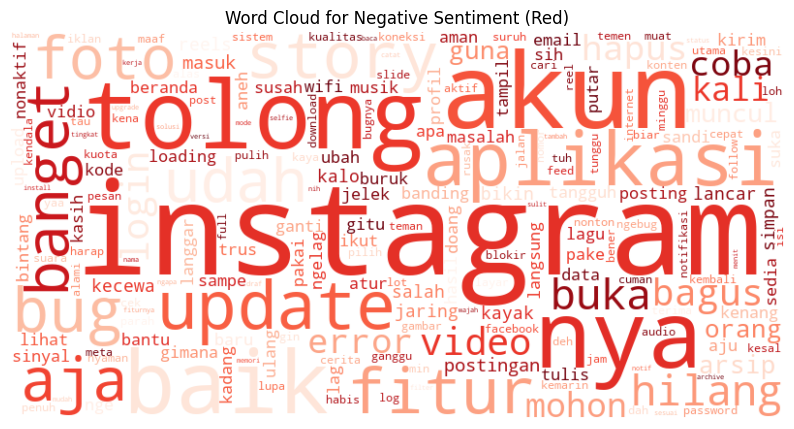

In [12]:
# Join all the positive and negative reviews into single strings
kata_negatif = ' '.join(sentimen_negatif)

# Tokenize the words and count frequency for negative sentiment
words_negatif = kata_negatif.split()
word_counts_negatif = Counter(words_negatif)

# Display the most common words for negative sentiment
common_words_negatif = word_counts_negatif.most_common(10)

# Create word cloud for negative sentiment with a red colormap
wordcloud_negatif = WordCloud(
    width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(word_counts_negatif)

# Plotting the word cloud for negative sentiment
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negatif, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Negative Sentiment (Red)")
plt.show()

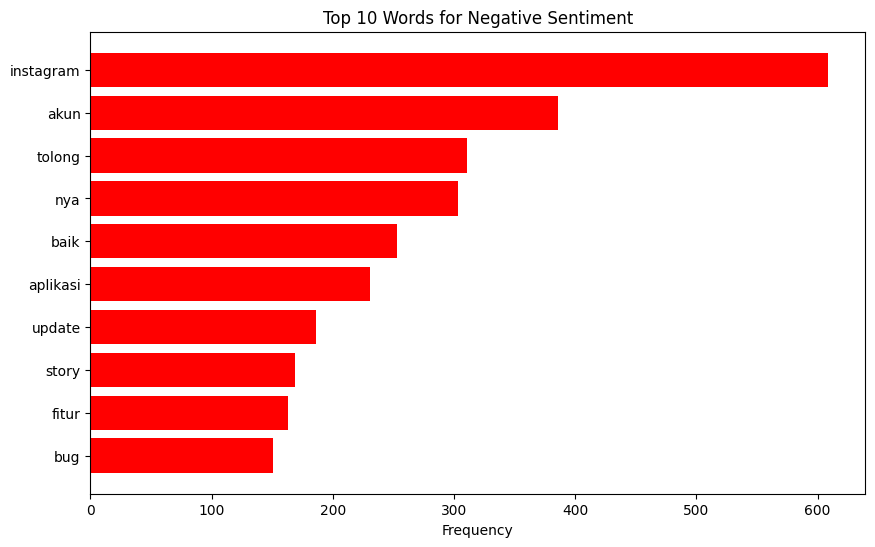

In [13]:
# Optional: Plot the top 10 words as bar plots for negative sentiment
top_words_negatif = [word[0] for word in common_words_negatif]
top_counts_negatif = [word[1] for word in common_words_negatif]

plt.figure(figsize=(10, 6))
plt.barh(top_words_negatif, top_counts_negatif, color='red')
plt.xlabel('Frequency')
plt.title('Top 10 Words for Negative Sentiment')
plt.gca().invert_yaxis()
plt.show()


## 6. Modelling and Evaluation

In [14]:
X = df['Stemming']
y = df['sentiment']
tfid = TfidfVectorizer()
X_tfid =  tfid.fit_transform(X)
pickle.dump(tfid, open('Streamlit/vectorizer.pkl', 'wb'))
print('File tersimpan')

In [25]:
pickle.dump(tfid, open('Streamlit/vectorizer.pkl', 'wb'))

In [15]:
# Handling imbalanced using SMOTE
smote = SMOTE(random_state=42)
x_sm,y_sm = smote.fit_resample(X_tfid,y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x_sm, y_sm, test_size = 0.2,random_state=42)
print(f'X_train Shape: {X_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (1552, 2591)
X_test Shape: (389, 2591)
y_train Shape: (1552,)
y_test Shape: (389,)


In [17]:
acc = []
f1_scores = []
precision_scores = []
recall_scores = []

In [18]:
list_model = {'RandomForestClassifier':RandomForestClassifier(random_state=42),
              'DecisionTreeClassifier':DecisionTreeClassifier(random_state=42),
              'LogisticRegression':LogisticRegression(random_state=42),
              'Naive Bayes':MultinomialNB(),
              'KNN':KNeighborsClassifier(),
              'SVM':SVC(kernel='linear'),
              }

In [19]:
for name_model,model in list_model.items():
    print(f'Training model {name_model}....')
    model.fit(X_train,y_train)
    # pickle.dump(model, open(f'Streamlit/{name_model}.pkl', 'wb'))
    # print(f'File {name_model}.pkl tersimpan')
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred) * 100
    accuracy = f"{accuracy:.1f}%"
    report = classification_report(y_test, y_pred, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    acc.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    print(f'Training model {name_model} Done')

Training model RandomForestClassifier....
Training model RandomForestClassifier Done
Training model DecisionTreeClassifier....
Training model DecisionTreeClassifier Done
Training model LogisticRegression....
Training model LogisticRegression Done
Training model Naive Bayes....
Training model Naive Bayes Done
Training model KNN....
Training model KNN Done
Training model SVM....
Training model SVM Done


### Save The Evaluation Models

In [20]:
models = [
    'RandomForestClassifier',
    'DecisionTreeClassifier',
    'LogisticRegression',
    'Naive Bayes',
    'KNeighborsClassifier',
    'SVM'
]
result_model = {
    'Model': models,
    'Accuracy':acc,
    'F1_Score': f1_scores,
    'Recall': recall_scores,
    'Precisions': precision_scores,
}
df_model = pd.DataFrame(result_model)

In [21]:
df_model.sort_values(by='Accuracy',ascending=False,ignore_index=True)

,Model,Accuracy,F1_Score,Recall,Precisions
0,RandomForestClassifier,91.8%,0.918828,0.917738,0.925450
1,SVM,89.5%,0.893663,0.894602,0.894957
2,LogisticRegression,87.1%,0.870770,0.871465,0.871669
3,Naive Bayes,79.7%,0.794447,0.796915,0.812976
4,DecisionTreeClassifier,73.0%,0.729313,0.730077,0.729701
5,KNeighborsClassifier,65.6%,0.556268,0.655527,0.778645


the best model for this dataset is **RandomForestClassifier**

## 7. Testing

In [46]:
# Mengubah input menjadi fitur menggunakan TF-IDF
new_data = input('Masukkan Kalimat: ')
print(f'Kalimat : {new_data}')
testing = tfid.transform([new_data])

for name_model,model in list_model.items():
    predict = model.predict(testing)[0]
    print(f'Model "{name_model}" memprediksi : {predict}')

Kalimat : aplikasi jelek dan banyak bug
Model "RandomForestClassifier" memprediksi : negatif
Model "DecisionTreeClassifier" memprediksi : negatif
Model "LogisticRegression" memprediksi : negatif
Model "Naive Bayes" memprediksi : negatif
Model "KNN" memprediksi : netral
Model "SVM" memprediksi : negatif
